### Read OISST v2 data via Thredds, save data into disk and then remap data to the POP2 1 degree grid

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import xarray as xr
import pop_tools
import xesmf, os, getpass
from misc import get_ij
from distributed import Client
from ncar_jobqueue import NCARCluster
# Load marineHeatWaves definition module
import marineHeatWaves as mhw

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
base_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/'
files = [f'{base_url}sst.day.mean.{year}.v2.nc' for year in range(1981, 2021)]
#files
#https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc.html

Download the oisst dataset on scratch, if that has not been done already.

In [3]:
path = '/glade/scratch/{}/noaa.oisst.v2.highres/'.format(getpass.getuser())
os.system('mkdir '+path)

mkdir: cannot create directory ‘/glade/scratch/gmarques/noaa.oisst.v2.highres/’: File exists


256

In [10]:
for f in files:
  if (not os.path.lexists(path+f[-23:])):
    print(f)
    ds = xr.open_dataset(f, chunks={'time': '100MB'})
    ds.to_netcdf(path+f[-23:])

https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2003.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2004.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2005.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2006.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2007.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2008.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2009.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2010.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2011.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2012.v2.nc
https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2013.v2.nc
https://ps

In [11]:
cluster = NCARCluster(cores=4,
    processes=1,
    resource_spec='select=1:ncpus=1:mem=50GB',
)
cluster.scale(20)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.24:35303,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
%%time
data = xr.open_mfdataset(path+'*.nc', parallel=True)

CPU times: user 405 ms, sys: 234 ms, total: 639 ms
Wall time: 16 s


### Case study #1: 2011 Western Australia event

As an example, let look at a SST plot off Western Australia using a single day from the AVHRR satellite data. On the same plot we will and overlay the point for case 1 (WA; 112.5 ∘ E, 29.5 ∘ S) on the AVHRR grid and on the LENS2 POP grid. We will also plot the two grids on the map.

In [13]:
# add coordinates for cell edges
lon_c = np.zeros(len(data.lon)+1)
lon_c[1:-1] = 0.5 * (data.lon.values[0:-1]+data.lon.values[1::])
lon_c[0] = 0.
lon_c[-1] = 360
data = data.assign_coords(lon_c=('lon_c', lon_c))

lat_c = np.zeros(len(data.lat)+1)
lat_c[1:-1] = 0.5 * (data.lat.values[0:-1]+data.lat.values[1::])
lat_c[0] = -90
lat_c[-1] = +90
data = data.assign_coords(lat_c=('lat_c', lat_c))

[X,Y] = np.meshgrid(lon_c, lat_c)

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


i = 135, j = 93


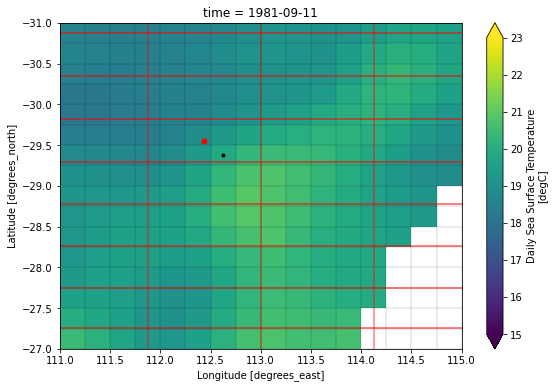

In [14]:
pop_grid = pop_tools.get_grid('POP_gx1v7')
i, j = get_ij(112.5, -29.5, pop_grid)
print('i = {}, j = {}'.format(i,j))

dummy = data.sst.sel(lon = 112.5, lat = -29.5, method='nearest')[0]
fig, ax = plt.subplots(1,1, figsize=(9,6))
data.sst[10,:].plot(ax=ax, vmin=15,vmax=23)
# sst grid
ax.plot(X,Y,'k',alpha=0.1)
ax.plot(X.transpose(),Y.transpose(),'k',alpha=0.1)
ax.plot(dummy.lon.values, dummy.lat.values, color='k', ms=3,marker='o')

# pop grid
ax.plot(pop_grid.ULONG,pop_grid.ULAT,'r',alpha=0.5)
ax.plot(pop_grid.ULONG.transpose(),pop_grid.ULAT.transpose(),'r',alpha=0.5)
ax.plot(pop_grid.TLONG[j,i], pop_grid.TLAT[j,i], color='r', 
        ms=5,marker='o');

#ax.plot([111.5,113.5,113.5,111.5,111.5],[-30.5,-30.5,-28.5,-28.5,-30.5],'k')
ax.set_xlim(111,115)
ax.set_ylim(-27,-31);

### Remap SST data to POP_gx1v7

In [15]:
pop_grid = pop_tools.get_grid('POP_gx1v7')

ds_in = data.rename({'lon_c': 'lon_b','lat_c': 'lat_b',})
ds_out = pop_grid.rename({'TLAT': 'lat','TLONG': 'lon', 'ULAT' : 'lat_b', 'ULONG' : 'lon_b'})

In [16]:
def regrid_tracer(fld, ds_in, ds_out, method='bilinear'):

    regrid = xesmf.Regridder(
        ds_in,
        ds_out,
        method=method,
        periodic=True,
    )
    fld_out = regrid(ds_in[fld])
    return fld_out

In [17]:
%%time
sst_regridded = regrid_tracer('sst', ds_in, ds_out)

CPU times: user 15.3 s, sys: 288 ms, total: 15.6 s
Wall time: 16.6 s


In [20]:
sst_regridded.to_netcdf(path+'oisst_regridded_POP_gx1v7.nc')

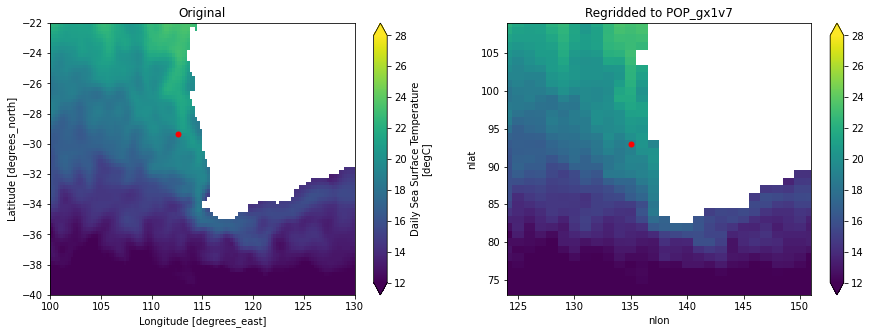

In [24]:
# compare the original and remmaped data
%matplotlib inline
dummy = data.sst.sel(lon = 112.5, lat = -29.5, method='nearest')[0]
fig, ax = plt.subplots(1,2, figsize=(15,5))
data.sst[0,:].plot(ax=ax[0], vmin=12,vmax=28)
ax[0].plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax[0].set_xlim(100,130)
ax[0].set_ylim(-40,-22);
ax[0].set_title('Original')

sst_regridded[0,:].plot(ax=ax[1], vmin=12,vmax=28)
ax[1].plot([135], [93], color='r', ms=5,marker='o')
ax[1].plot([111.5,113.5,113.5,111.5,111.5],[-30.5,-30.5,-28.5,-28.5,-30.5],'k')
ax[1].set_xlim(124,151)
ax[1].set_ylim(73,109);
ax[1].set_title('Regridded to POP_gx1v7');

Let's load daily time series of SST (from the original and remapped dataset) off Western Australia (WA; 112.5 ∘ E, 29.5 ∘ S, red dot above) over the 1982 to 2014 period:

##### Select time-series

In [25]:
%%time
wa_ds = data.sst.sel(lon = 112.5, lat = -29.5, 
             method='nearest').sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 540 ms, sys: 30.5 ms, total: 571 ms
Wall time: 6.88 s


In [27]:
wa_ds

<xarray.DataArray 'sst' (time: 12053)>
array([20.939999, 21.25    , 21.38    , ..., 20.27    , 20.42    ,
       20.39    ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2014-12-31
    lon      float32 112.6
    lat      float32 -29.38
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]
    _ChunkSizes:   [   1  720 1440]

In [28]:
#wa_ds.to_netcdf('wa_ds.nc')

In [30]:
%%time
wa_ds_regridded = sst_regridded.isel(nlon = i, nlat = j).sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 885 ms, sys: 54 ms, total: 939 ms
Wall time: 10.1 s


In [31]:
wa_ds_regridded

<xarray.DataArray (time: 12053)>
array([21.01956 , 21.124851, 21.159773, ..., 20.324919, 20.419828,
       20.429815], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2014-12-31
    lon      float64 112.4
    lat      float64 -29.55
Attributes:
    regrid_method:  bilinear

In [63]:
#wa_ds_regridded.to_netcdf('wa_ds_regridded.nc')

In [17]:
###Uncomment line below to start from here
#wa_ds=xr.open_dataset('wa_ds.nc').sst
#wa_ds_filtered=xr.open_dataset('wa_ds_filtered.nc').sst

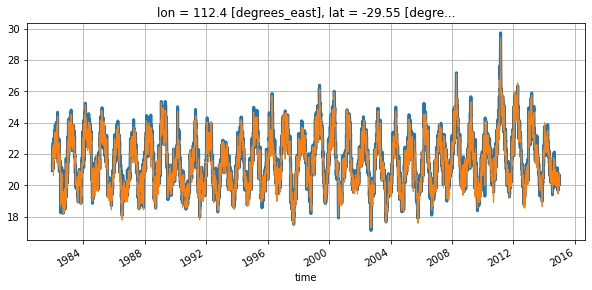

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
wa_ds.plot(ax=ax, label='oisst', lw=3)
wa_ds_regridded.plot(ax=ax, label='oisst_remmaped', lw=1)
ax.grid()

### Marine Heatwave Detection
The marineHeatWaves (mhw) module consists of a number of functions for the detection and characterization of MHWs. The main function is the detection function (detect) which takes as input a time series of temperature (and a corresponding time vector) and outputs a set of detected MHWs.

Next we run the MHW detection algorithm which returns the variable mhws, consisting of the detected MHWs, and clim, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:

In [37]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [38]:
len(t)

12053

In [40]:
mhws_case1_true, clim_case1_true = mhw.detect(t, wa_ds.values)
mhws_case1_remap, clim_case1_remap = mhw.detect(t, wa_ds_regridded.values)

This algorithm has detected the following number of MHW events:

In [42]:
mhws_case1_true['n_events']

60

In [43]:
mhws_case1_remap['n_events']

60

The first ten events, for example, have the following maximum intensities (in C)  

In [44]:
mhws_case1_true['intensity_max'][0:10]

[1.9759563938263902,
 2.1255383645334582,
 2.241348082019435,
 1.2863466816563793,
 1.8312707716418863,
 1.5018472363871922,
 2.2082389708488286,
 1.1157563117242653,
 1.690619499452648,
 1.9938329881237422]

In [45]:
mhws_case1_remap['intensity_max'][0:10]

[1.3277950902139004,
 1.897887629847368,
 2.234155777961977,
 2.2357692103232125,
 1.7692741886261985,
 1.7350290975263043,
 1.8420706718198723,
 2.0434194995510992,
 1.9530748551891683,
 1.711446085283832]

Let's have a look at some properties of the event with the largest maximum intensity

In [46]:
ev = np.argmax(mhws_case1_true['intensity_max']) # Find largest event
print ('Maximum intensity:', mhws_case1_true['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case1_true['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case1_true['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case1_true['duration'][ev], 'days')
print ('Start date:', mhws_case1_true['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case1_true['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 6.483709366090839 deg. C
Average intensity: 3.1762778888865806 deg. C
Cumulative intensity: 193.7529512220814 deg. C-days
Duration: 61 days
Start date: 06 February 2011
End date: 07 April 2011


In [47]:
ev = np.argmax(mhws_case1_remap['intensity_max']) # Find largest event
print ('Maximum intensity:', mhws_case1_remap['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case1_remap['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case1_remap['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case1_remap['duration'][ev], 'days')
print ('Start date:', mhws_case1_remap['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case1_remap['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 6.354586447438891 deg. C
Average intensity: 3.2896328405382524 deg. C
Cumulative intensity: 177.64017338906564 deg. C-days
Duration: 54 days
Start date: 07 February 2011
End date: 01 April 2011
